<a href="https://colab.research.google.com/github/erin-baggs/DuckweedMicrobes/blob/main/family_order_indiv_R_processing_16S.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Colab R 

Typically google colab notebooks run primarily through python but as we want to customize visualizations of results today we will be using an R based google colab. Using an R based colab does however make it harder for us to access our google drive so the steps to link to drive may take a bit longer than with the prior notebook. 

Before we start so you can keep any changes you make a copy of this notebook in google drive.  File -> Save a copy in drive.

### Establish connection between R and Google drive 



In order to have a convenient place to save and retrieve our data from we will establish a connection to google drive. To do this we will install with 

```
install.packages
```
and activate within our current session 

```
library() 
```

 packages that have been written by developers to allow the interfacing between google colab and our google drives. 

In [ ]:
install.packages("googledrive")
library("googledrive")
install.packages("httpuv") 
library("httpuv")

In [ ]:
if (file.exists("/usr/local/lib/python3.7/dist-packages/google/colab/_ipython.py")) {
  install.packages("R.utils")
  library("R.utils")
  library("httr")
  my_check <- function() {return(TRUE)}
  reassignInPackage("is_interactive", pkgName = "httr", my_check) 
  options(rlang_interactive=TRUE)
}

# **Authorizing drive**

To link Gdrive run the cell below. 
This should generate a URL, when clicked the URL takes you to a pop up that will ask you which google account to use, then will ask for permission to link. Tick the box 'see, edit, create and delete Google Drive files'(example below).
Then in the next screen of the tab there is an authorization code you can copy (example below). Then navigate back to this work book and paste the authorization code into the box that will appear in the cell below.  

**DIRECTLY BELOW IS IMAGE OF WHAT CELL WILL LOOK LIKE WHEN RUN **

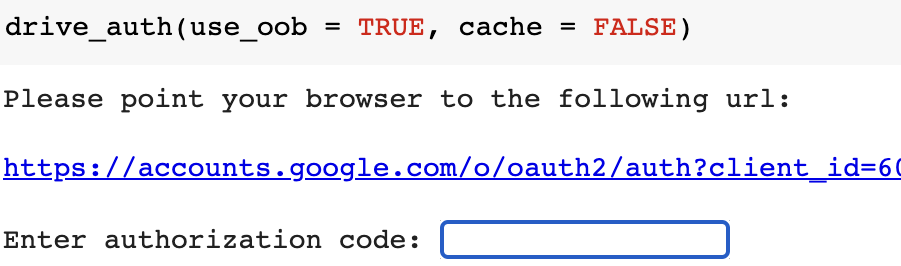

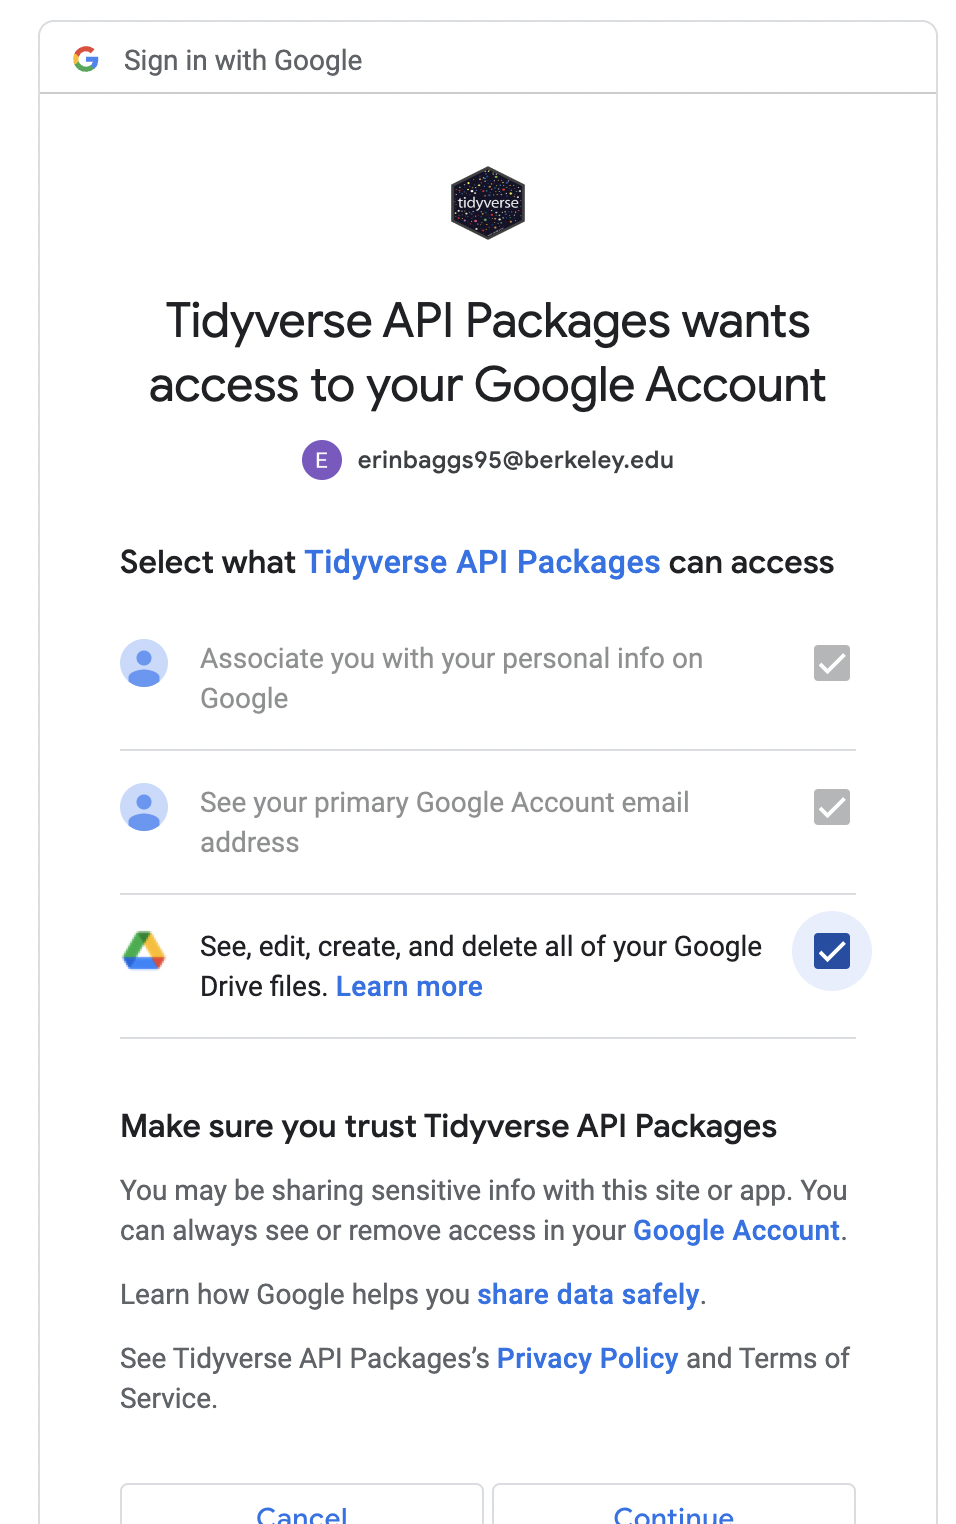

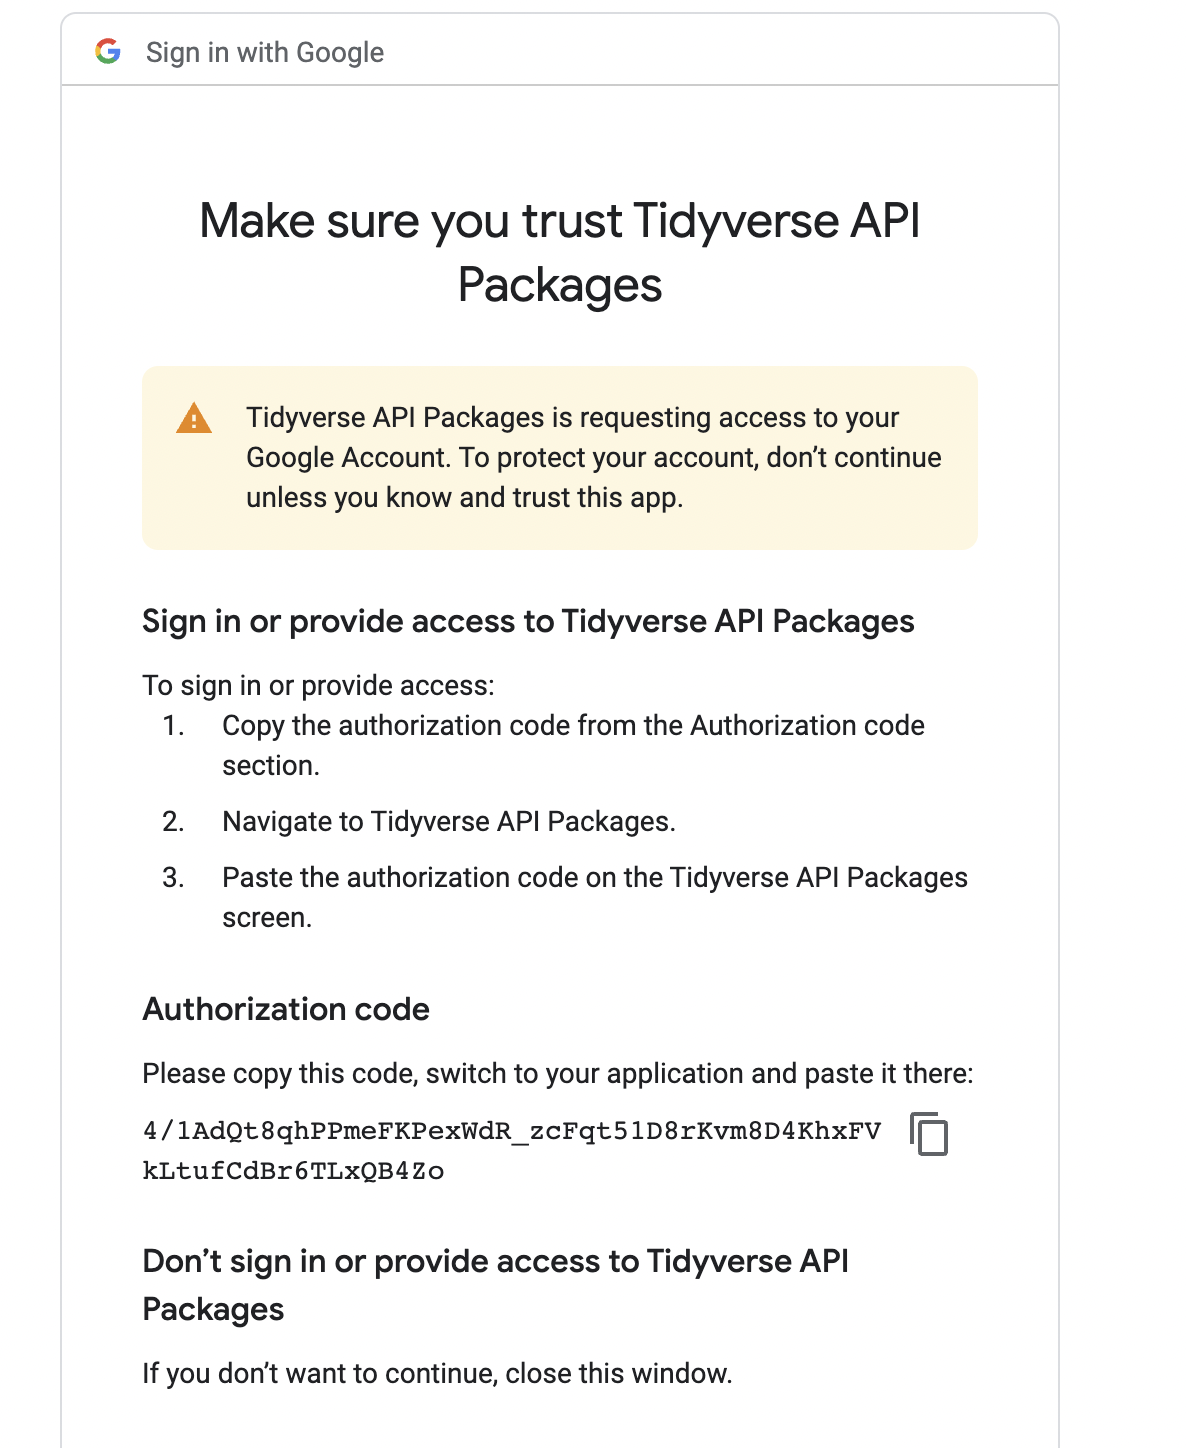

In [ ]:
drive_auth(use_oob = TRUE, cache = FALSE)

# Install packages for subsampling and ecology statistics

Now that we can access the data in our drive from last session we want to install tools to use in R which can help us to refine and analyse our data. Further information is available below on the packages we will depend on most.  

Information on why to use [SRS](https://peerj.com/articles/9593/) for normalization. Details on the [SRS](https://cran.r-project.org/web/packages/SRS/SRS.pdf) package used to create equivalent abundance values from different sized libraries through scaling with ranked subsampling. 

Information on the R package Vegan for investigating community ecology statistics. Vegan [package](https://cran.r-project.org/web/packages/vegan/vegan.pdf) options/ contents  

Information on [ggplot2](https://ggplot2.tidyverse.org/) package used to create charts and graphs. There is a lot of information online that is really helpful for adjusting ggplot figures. 

In [ ]:
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install("ggtree")
BiocManager::install("ape")
install.packages('SRS')
install.packages('vegan')
install.packages('ggplot2')
install.packages('ggstar')
BiocManager::install("treeio")
install.packages("reshape2")
library('SRS')
library('vegan')
library('ggplot2')
library('ggtree')
library('ggstar')
library('treeio')
library('ape')
library('reshape2')

# Retrieve data from 1st colab notebook

As we are in R we can no longer pull data in as easily, instead you will need to replace the link below with the data you want to use.

In your google drive you should be able to find the abundance tables in the 16Scolab/abundanceTables folder.If you have a file with suffix taxid ignore this one for now. If you didnt finish the session on Wednesday then you can use the links in [gdocs](https://docs.google.com/document/d/1Zlix1a3b1HQKP87ktYuoLt0sxomP9QCKaaJcjQGvt1g/edit?usp=sharing). 
 

Replace the links below with links to your own google drive folder containing the minimap output abundance tables. 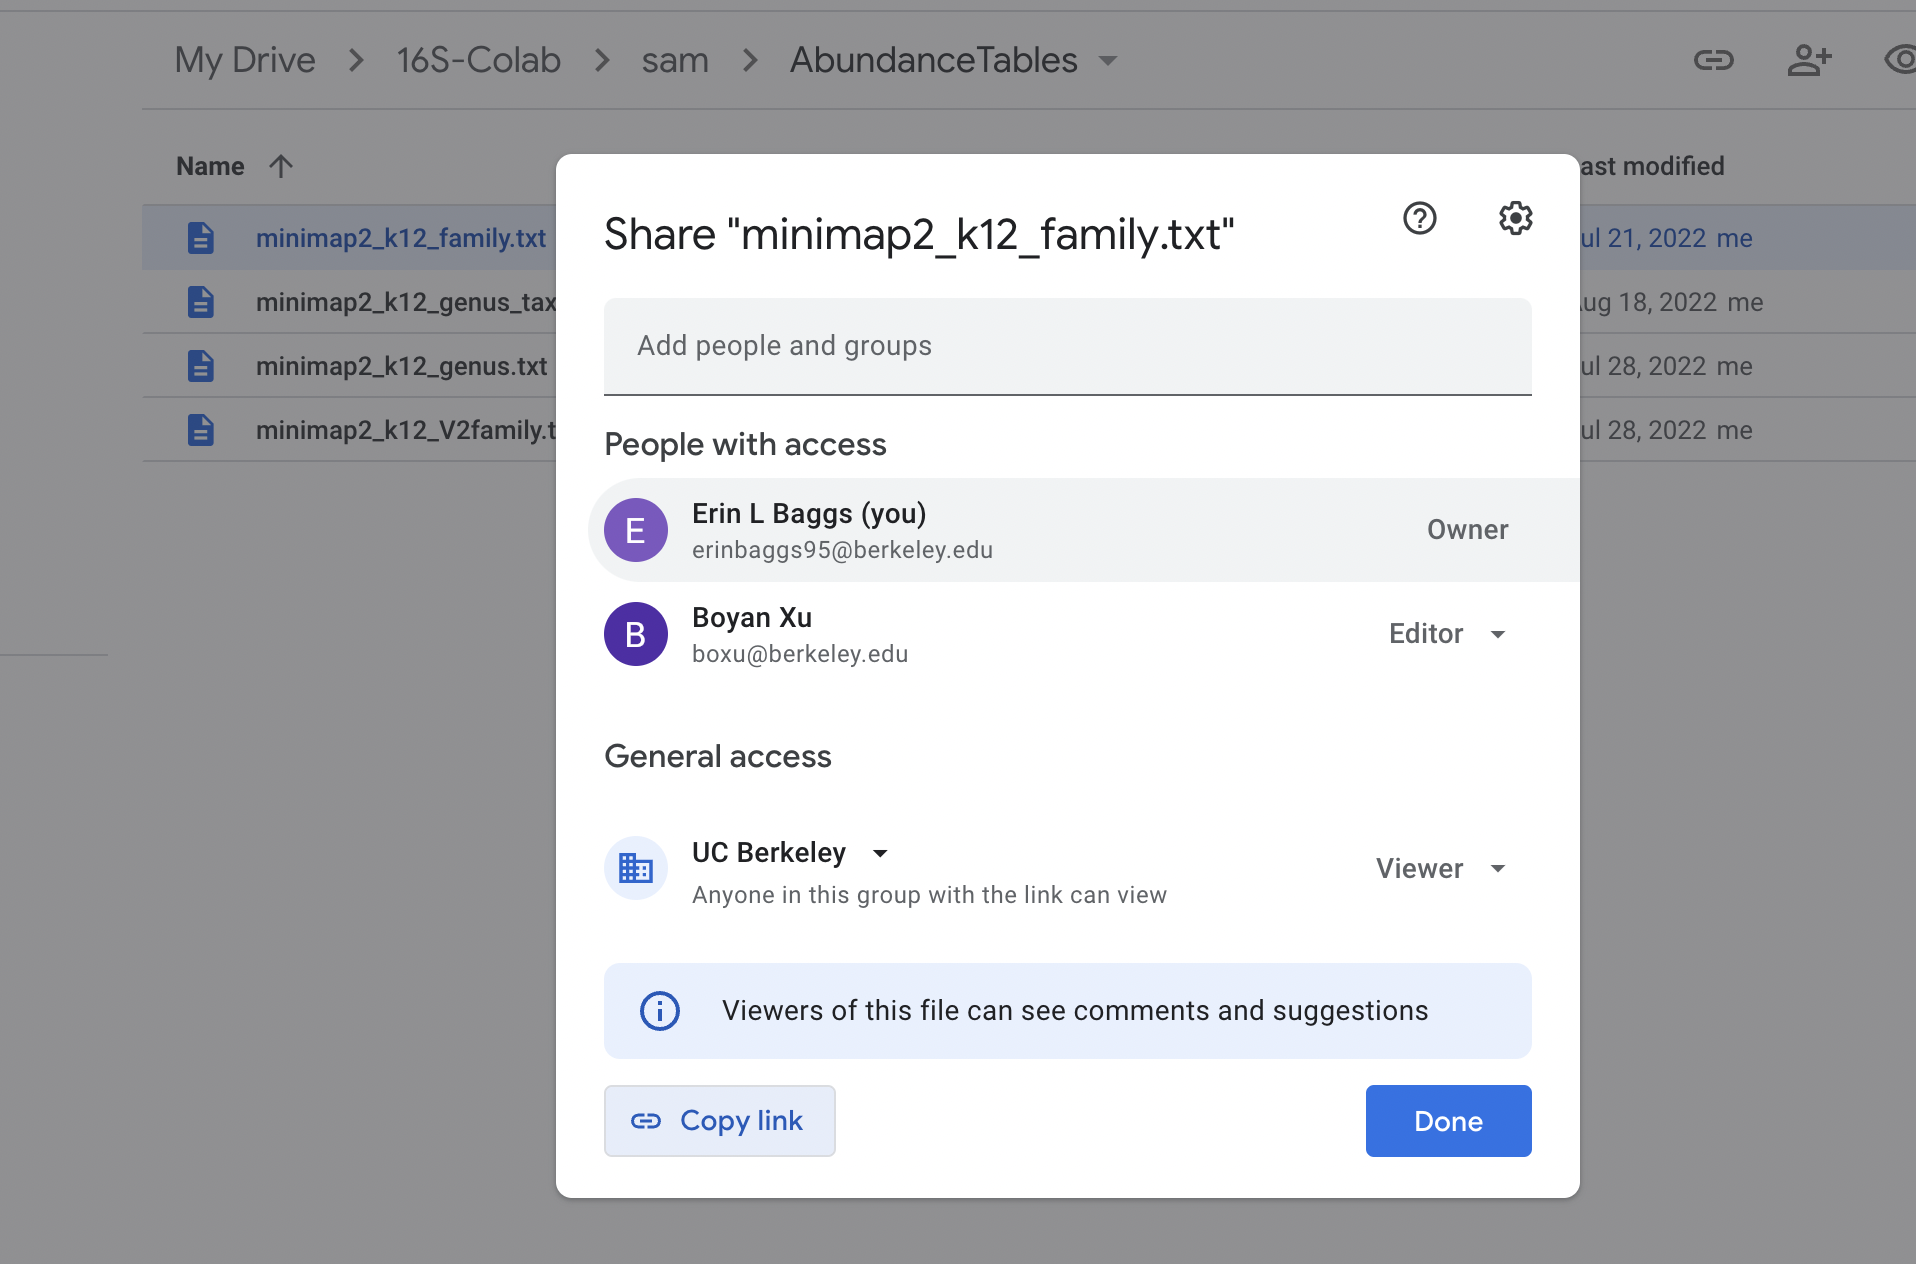

In [ ]:
### ! IMPORTANT REPLACE LINK BELOW with links to minimap tables you generated 
### in first workshop and saved to MyDrive ####
genus <- "https://drive.google.com/file/d/166tZ27qYOfpQvl68JDn7OZ0D4Mf-v_P3/view?usp=sharing" #creating shorthand link to path
drive_get(genus) #creates a link to the file
drive_download(genus) #downloads the file into your content folder in google colab

In [ ]:
family <- "https://drive.google.com/file/d/15xd3I0LNPKXd9I4GDOzNZ-YSGoHy1d3c/view?usp=sharing"
drive_get(family)
drive_download(family)

In [ ]:
order <- "https://drive.google.com/file/d/16FpjTg-YAxd3TT3wSroAvp8BhEUYgI1r/view?usp=sharing"
drive_get(order)
drive_download(order)

After downloading the files they will appear in your content folder that is a temporary folder during your colab session. You can see this by pressing the folder icon on the left hand side toolbar. The output from the cell above once run will also tell you the name that your file is save as in your content folder. With the sidebar that shows your colab session files you may need to press the folder icon with a circular arrow to see the updated folder contents. 

To continue we are going to import our tables from our goolge colab session content into an R object. To do this you will need to replace the name after /content/ if it difffers from what your table was saved locally. You will need to do this for both the genusT and familyT cells. 

In [ ]:
orderT <- read.csv("/content/minimap2_k12_order.txt",sep = "\t",header=TRUE ) #Import the table into R this requires you to tell R the path how rows are seperated ie sep and whether there are titles to rows ie header =TRUE
head(orderT)

In [ ]:
familyT <- read.csv("/content/minimap2_k12_family.txt",sep = "\t",header=TRUE )
head(familyT)

In [ ]:
genusT <- read.csv("/content/minimap2_k12_genus.txt",sep = "\t",header=TRUE )
head(genusT)

# Rarefying Scaling with Ranked Subsampling (SRS)  data 

We will first look are rarefying (we use [rarefy](https://rdrr.io/cran/vegan/man/rarefy.html) package to do this), this generates a random sub-sample of all the independent conditions. The subsamples are equal to the total number of reads in the least well sampled condition. This has historically been the most commonly used process however it has a number of problems, that we will see later. 

From here on the tutorial is written for just the genus abundance table. Once you have run through the tutorial and have results for the genus level, why not test your understanding of what is going on by converting it from running on genus to your family or even try going back to the other notebook to generate order abundance tables that you can use with the following scripts.   



To continue we reformat the table  to move species from rows to columns. 
To do this first we remove the taxa identifiers that are in column 1, we will add these back before normalizing. 

In [ ]:
familyT2 <- familyT[c(2:16)] #This select columns 2-4 of table genusT and copies them to genusT2
head(familyT)
#orderT2 <- orderT[c(2:16)] #This select columns 2-4 of table genusT and copies them to genusT2
#head(orderT)

In [ ]:
genusT2 <- genusT[c(2:16)] #This select columns 2-4 of table genusT and copies them to genusT2
head(genusT)

Before we can normalize read count across the three sites we need to calculate the total number of reads per site then identify the site with lowest total number of reads out of the three. 

In [ ]:
CminF<-min(colSums(familyT2)) #sum up each individual column in genusT2 table and then store lowest value in CminG
CminF
#CminO<-min(colSums(orderT2)) #sum up each individual column in genusT2 table and then store lowest value in CminG
#CminO

In [ ]:
CminG<-min(colSums(genusT2)) #sum up each individual column in genusT2 table and then store lowest value in CminG
CminG

Next we switch the rows and columns using 
NB. below we use the '<>' annotation style this is commonly used in coding and indicates that you should replace the arrow heads and phrase inside with the object name that is the one you are trying to perform the action on.



```
as.data.frame(t(<your new table name>))
```
Before adding the species names back in as column names through 


```
colnames(<your new table name>)<-<your old table name>[,1]
```




In [ ]:
#Swap columns and rows for rarefy required input layout
family_df <- as.data.frame(t(familyT2)) #convert table to data.frame type object with t indicating switch of columns and rows
colnames(family_df)<-familyT[,1] # Add the genus names which where 1st column of genusT back in as column names in Genus_df table
head(family_df)
#Swap columns and rows for rarefy required input layout
order_df <- as.data.frame(t(orderT2)) #convert table to data.frame type object with t indicating switch of columns and rows
colnames(order_df)<-orderT[,1] # Add the genus names which where 1st column of genusT back in as column names in Genus_df table
head(order_df)

Now our data is prepared in the correct format we can use rarefy to see how downsampling to equivalent numbers effects species richness  and how this differs if we do not use rarefaction. 


In [ ]:
#Plot to see how downsampling to equivalent numbers effects species richness 
rarecurve(Genus_df, step = 20, sample = CminG, col = "blue", cex = 0.6) #Plot species vs sample size after rarefy

###Calculate and plot the difference between observed species without attempting to normalize read depth and rarefy normalization of library size 

S <- specnumber(Genus_df) # observed number of species
raremax <- min(rowSums(Genus_df)) #calculate the smallest number of reads at any one of the sites 
Srare <- rarefy(Genus_df, raremax) #carry out rarefaction 
plot(S, Srare, xlab = "Observed No. of taxa", ylab = "Rarefied No. of taxa", xlim=c(540,660), ylim=c(540,660)) # Create plot 
text(Srare~S, labels=names(S), font=2, pos=1) #label graph
abline(lm(Srare ~ S)) # add line to graph

However, there are some problems with rarefaction (subsampling without replacement) the method implemented in rarefy can result in distortion of aloha diversity and poor reproducibility.
'Analysis of species count data in ecology often requires normalization to an identical sample size. Rarefying (random subsampling without replacement), which is the current standard method for normalization, has been widely criticized for its poor reproducibility and potential distortion of the community structure. In the context of microbiome count data, researchers explicitly advised against the use of rarefying. Here we introduce a normalization method for species count data called scaling with ranked subsampling (SRS) and demonstrate its suitability for the analysis of microbial communities.' from [SRS](https://peerj.com/articles/9593/) publication.  Therefore we are going to look at a new method that has been shown to not suffer from the same issues as rarefaction - scaling with ranked subsampling (SRS). This uses rarefaction as only a last resort in cases where the difference would be 1 read, this avoids complete loss of OTUs that can occur from rarefaction alone. 

If you are interested to read more on this follow the link to the SRS methods paper linked above.

Then using these count tables we normalize all columns to the Cmin values using scaling with ranked subsampling. 

In [ ]:
SRS_outputF2 <- SRS(familyT2, CminF, set_seed=TRUE) #Carry out Scaling with Ranked Subsampling (SRS)
row.names(SRS_outputF2)<-familyT[,1] #Add genus names back to table 
SRS_outputF2 #Print result to output to see what you created 
SRS_outputG2 <- SRS(genusT2, CminG, set_seed=TRUE) #Carry out Scaling with Ranked Subsampling (SRS)
row.names(SRS_outputG2)<-genusT[,1] #Add genus names back to table 
SRS_outputG2 #Print result to output to see what you created 

In [ ]:
SRS_outputO2 <- SRS(orderT2, CminO, set_seed=TRUE) #Carry out Scaling with Ranked Subsampling (SRS)
row.names(SRS_outputO2)<-orderT[,1] #Add genus names back to table 
SRS_outputO2 #Print result to output to see what you created 

Now we want to save our SRS normalized data to our drive so that we have it for future reference. You could add to the code below to save your rarefy data as well if you wanted to keep it. 

Remember if you are re-running with family data to write.csv / save the drive upload first value to a different name and the name = field to the name you used for family output. 

In [ ]:
#drive_mkdir("16SColab/SRS-indiv/") #Make a folder in google drive
write.csv(SRS_outputF2,"SRS_outputF-10-4.csv", row.names = TRUE) #Save our table localy to content 
#drive_upload("SRS_outputF-10-4.csv", name = "SRS_outputF-10-4", path ="16SColab/SRS-indiv") #Upload our saved file to drive 
write.csv(SRS_outputG2,"SRS_outputG-10-4.csv", row.names = TRUE) #Save our table localy to content 
#drive_upload("SRS_outputO-10-4.csv", name = "SRS_outputO-10-4", path ="16SColab/SRS-indiv") #Upload our saved file to drive 

# Ecology

With our reads per pond now normalized to the smallest library, we can start to anlayse the differences between the ponds. 

To start we will utilize the R package Vegan which is for investigating community ecology statistics. 

[Explanation](https://cran.r-project.org/web/packages/vegan/vignettes/diversity-vegan.pdf) of diversity metrics 
  

[Design principles](https://cran.r-project.org/web/packages/vegan/vignettes/decision-vegan.pdf) to consider when implementing vegan 

### Diversity metrics

**Species richness:** is the number of different species represented in an ecological community, landscape or region. Species richness is simply a count of species, and it does not take into account the abundances of the species or their relative abundance distributions.

**Species evenness:** takes into account the number of species and the relative abundance of species in a community.


**Diversity Indices:**
A diversity index is a mathematical measure of species diversity in a given community. Based on the species richness (the number of species present) and species abundance (the number of individuals per species). There are two types of indices, dominance indices and information statistic indices.

**The Shannon index:** is an information statistic index, which means it assumes all species are represented in a sample and that they are randomly sampled. Can you point
out any problems in these assumptions? In the Shannon index, p is the proportion (n/N) of individuals of one particular species found (n) divided by the total number of individuals found (N), ln is the natural
log, Σ is the sum of the calculations, and s is the number of species.

**The Simpson index:** is a dominance index because it gives more weight to common or dominant species. In this case, a few rare species with only a few representatives will not affect the diversity. Can you point out any problems in these assumptions? In the Simpson index, p is the proportion (n/N) of individuals of one particular
species found (n) divided by the total number of individuals found (N), Σ is still the sum
of the calculations, and s is the number of species. 

Inverse Simpson index is the effective number of types that 
is obtained when the weighted arithmetic mean is used to quantify average proportional abundance of types in the dataset of interest

From our abundance tables before and after normalization we can look at the taxa richness across the three sites. 

The first cell generates the richness plot with non-normalized data and rarefy output. The second cell generates a richness plot for the SRS and rarefy normalized counts. 

In [ ]:
SRSplot<-SRScurve(familyT2, metric = "richness", step = 500,
rarefy.comparison = TRUE ,ylab = "richness", rarefy.comparison.legend = TRUE,label=TRUE,
lty = c(1,2)) 
pdf(file="family-richness.pdf")
SRSplot
dev.off()

In [ ]:
SRSplot<-SRScurve(genusT2, metric = "richness", step = 500,
rarefy.comparison = TRUE ,ylab = "richness", rarefy.comparison.legend = TRUE, label=TRUE,
lty = c(1,2)) 
legend(45000, 55, legend=c("404", "405","923"),col=c("red", "blue","black"), lty=1, cex=0.8) #Create legend for the different line colours


To get the exact values of species richness per site after SRS and rarefy normalization we can use vegan statistics but we first need to switch the rows and columns. 

Given your subsample size from workshop 1 do rarefy and SRS give you similar values for species richness. If they did not why do you think this maybe? The graph plot above may help you with your answer. Maybe compare with your class mates and see if they got similar results. 

We will continue by looking at other diversity metric but only with SRS data you can however switch it to rarefy output if you want to try something different. 

In [ ]:
## SRS data follow on 
"SRS Shannon Diversity plot "
shan <- diversity(Family_SRS, index = "shannon") #using vegan functions calculate diversity index
print(shan)
shan2<-as.data.frame(shan) #convert results from list to data frame 
xlab<-(rownames(shan2)) #label the x-axis 
print(shan2)
q<-ggplot(data=shan2, aes(x=xlab, y=shan))+geom_bar(stat="identity") # Make plot 
q+ ggtitle("Plot of shannon diversity at each site") +
  xlab("Site") + ylab("shannon diversity") #Add titles to plot 
ggsave("shan-div-indiv-family.pdf", plot = q)

In [ ]:
shanO <- diversity(Order_SRS, index = "shannon") #using vegan functions calculate diversity index
print(shanO)
shan2O<-as.data.frame(shanO) #convert results from list to data frame 
xlab<-(rownames(shan2O)) #label the x-axis 
print(shan2O)
q<-ggplot(data=shan2O, aes(x=xlab, y=shan))+geom_bar(stat="identity") # Make plot 
q+ ggtitle("Plot of shannon diversity at each site") +
  xlab("Site") + ylab("shannon diversity") #Add titles to plot 
ggsave("shan-div-indiv-order.pdf", plot = q)

In [ ]:
simp <- diversity(Family_SRS, index = "simpson")
print(simp)
simp2<-as.data.frame(simp)
xlab<-(rownames(simp2))
p<-ggplot(data=simp2, aes(x=xlab, y=simp))+geom_bar(stat="identity")
p + ggtitle("Plot of simpson diversity at each site") +
  xlab("Site") + ylab(" Simpson diversity")
ggsave("simp-div-indiv-fam.pdf", plot = p)

In [ ]:
simp <- diversity(Order_SRS, index = "simpson")
print(simp)
simp2<-as.data.frame(simp)
xlab<-(rownames(simp2))
p<-ggplot(data=simp2, aes(x=xlab, y=simp))+geom_bar(stat="identity")
p + ggtitle("Plot of simpson diversity at each site") +
  xlab("Site") + ylab(" Simpson diversity")
ggsave("simp-div-indiv-order.pdf", plot = p)

In [ ]:
invsimp <- diversity(Order_SRS, index = "invsimpson")
print(invsimp)
invsimp2<-as.data.frame(invsimp)
xlab<-(rownames(invsimp2))
p<-ggplot(data=invsimp2, aes(x=xlab, y=invsimp))+geom_bar(stat="identity")
p + ggtitle("Plot of inverse simpson diversity at each site") +
  xlab("Site") + ylab("Inverse simpson diversity")
ggsave("Invsimp-div-indiv-fam.pdf", plot = p)

In [ ]:
invsimp <- diversity(Order_SRS, index = "invsimpson")
print(invsimp)
invsimp2<-as.data.frame(invsimp)
xlab<-(rownames(invsimp2))
p<-ggplot(data=invsimp2, aes(x=xlab, y=invsimp))+geom_bar(stat="identity")
p + ggtitle("Plot of inverse simpson diversity at each site") +
  xlab("Site") + ylab("Inverse simpson diversity")
ggsave("Invsimp-div-indiv-order.pdf", plot = p)

In [ ]:
## Unbiased Simpson
unbias.simp <- simpson.unb(Family_SRS)
head(unbias.simp)
## Fisher alpha
alpha <- fisher.alpha(Family_SRS)
## Plot all
cbind(shan, simp, invsimp, unbias.simp, alpha)
names <- c(4,5,9)
head(names)
pdf(file="pairs-diversity-metric-plot-fam.pdf")
pairs(cbind(shan, simp, invsimp, unbias.simp, alpha), pch=names,oma=c(5,5,5,15))
par(xpd = TRUE)
dev.off()


In [ ]:
## Unbiased Simpson
unbias.simp <- simpson.unb(Order_SRS)
head(unbias.simp)
## Fisher alpha
alpha <- fisher.alpha(Order_SRS)
## Plot all
cbind(shan, simp, invsimp, unbias.simp, alpha)
names <- c(4,5,9)
head(names)
pdf(file="pairs-diversity-metric-plot-order.pdf")
pairs(cbind(shan, simp, invsimp, unbias.simp, alpha), pch=names,oma=c(5,5,5,15))
par(xpd = TRUE)
dev.off()

**Pielou's Evenness**

Pielou's evenness is an index that measures diversity along with species richness. While species richness is the number of different species in a given area, evenness is the count of individuals of each species in an area. 

A calculated value of Pielou's evenness ranges from 0 (no evenness) to 1 (complete evenness). When taken into account along with other indices such as Simpson's index or Shannon's index, a more thorough description of a community's structure can be interpreted.

In [ ]:
#Pielou's evenness
print("Pielous evenness Family")
SRF <- specnumber(Family_SRS)
shan/log(SRF)
print("Pielous evenness Order")
SRO <- specnumber(Order_SRS)
shanO/log(SRO)

# Visualization of data 

In [ ]:
taxidsFound <- read.csv("<SRS_normalized_output>",sep = "\t",header=TRUE )
Abund2<-taxidsFound[,-1:-2]
i1 <- order(decreasing = T,rowSums(Abund2[c("X404", "X405","X923")]))
Abund2new <- Abund2[i1, ]
Abund3<-subset(Abund2new, ranks!="uncultured")
head(Abund3)
tail(Abund3)
Abund4<- head(Abund3, n=10)
melted <- melt(Abund4, id.vars = c("ranks"))
head(melted)
melted$ranks <- factor(melted$ranks,levels=unique(melted$ranks)) # retain ordering top row sum of read values to lowest row sum values

Now we have formatted our data in the way we need we can generate a bubble plot. You can play with how the plot is colored and the size range of bubbles given what is appropriate for your data. 

In [ ]:
brks <- c(1,50,100,200,500,1000)
bubbleplot <- ggplot(melted, aes(x = variable, y = ranks)) + 
  geom_point(aes(size = value, fill = ranks), alpha = 0.75, shape = 21) + 
  scale_size_continuous(range = c(1,20),breaks=c(50,100,200)) + 
  labs( x= "Pond", y = "Species", size = "Reads per Genera", fill = "Species")  + 
  theme(legend.key=element_blank(), 
  axis.text.x = element_text(colour = "black", size = 12, face = "bold", angle = 90, vjust = 0.3, hjust = 1), 
  axis.text.y = element_text(colour = "black", face = "bold", size = 11), 
  legend.text = element_text(size = 10, face ="bold", colour ="black"), 
  legend.title = element_text(size = 12, face = "bold"), 
  panel.background = element_blank(), panel.border = element_rect(colour = "black", fill = NA, size = 1.2), 
  legend.position = "right") #+   
bubbleplot


# Relative abundance plots 

In [ ]:
install.packages("scales")
library(scales)
#SRS_out <- "https://drive.google.com/file/d/1YibX94OLdk0l40Q6L1Ua66Jm_GenFJ5D/view?usp=sharing"
#drive_get(SRS_out)
#drive_download(SRS_out)
#Lets test the tidyMicro pipeline
#https://rdrr.io/cran/tidyMicro/f/vignettes/tidy_micro_vignette.Rmd
SRS_outputG2 <- read.csv("/content/SRS_outputG-10-3.csv",sep = ",",header=TRUE )
SRS_outputF2 <- read.csv("/content/SRS_outputF-10-4.csv",sep = ",",header=TRUE )
SRS_outputO2 <- read.csv("/content/SRS_outputO-10-4.csv",sep = ",",header=TRUE )
head(SRS_outputG2)
head(SRS_outputO2)
head(SRS_outputF2)

In [ ]:
SRS_outputF2$X404.1= 100*(SRS_outputF2$X404.1/sum(SRS_outputF2$X404.1))
SRS_outputF2$X404.2= 100*(SRS_outputF2$X404.2/sum(SRS_outputF2$X404.2))
SRS_outputF2$X404.3= 100*(SRS_outputF2$X404.3/sum(SRS_outputF2$X404.3))
SRS_outputF2$X404.4= 100*(SRS_outputF2$X404.4/sum(SRS_outputF2$X404.4))
SRS_outputF2$X404.5= 100*(SRS_outputF2$X404.5/sum(SRS_outputF2$X404.5))

SRS_outputF2$X405.1= 100*(SRS_outputF2$X405.1/sum(SRS_outputF2$X405.1))
SRS_outputF2$X405.2= 100*(SRS_outputF2$X405.2/sum(SRS_outputF2$X405.2))
SRS_outputF2$X405.3= 100*(SRS_outputF2$X405.3/sum(SRS_outputF2$X405.3))
SRS_outputF2$X405.4= 100*(SRS_outputF2$X405.4/sum(SRS_outputF2$X405.4))
SRS_outputF2$X405.5= 100*(SRS_outputF2$X405.5/sum(SRS_outputF2$X405.5))

SRS_outputF2$X923.1= 100*(SRS_outputF2$X923.1/sum(SRS_outputF2$X923.1))
SRS_outputF2$X923.2= 100*(SRS_outputF2$X923.2/sum(SRS_outputF2$X923.2))
SRS_outputF2$X923.3= 100*(SRS_outputF2$X923.3/sum(SRS_outputF2$X923.3))
SRS_outputF2$X923.4= 100*(SRS_outputF2$X923.4/sum(SRS_outputF2$X923.4))
SRS_outputF2$X923.5= 100*(SRS_outputF2$X923.5/sum(SRS_outputF2$X923.5))
head(SRS_outputF2)
write.csv(SRS_outputF2,"SRS_outputF-10-3-percent.csv", row.names = TRUE) #Save our table localy to content 
drive_upload("SRS_outputF-10-3-percent.csv", name = "SRS_outputF-10-3-percent", path ="16SColab/SRS-indiv") #Upload our saved file to drive 

In [ ]:
SRS_outputO2$X404.1= 100*(SRS_outputO2$X404.1/sum(SRS_outputO2$X404.1))
SRS_outputO2$X404.2= 100*(SRS_outputO2$X404.2/sum(SRS_outputO2$X404.2))
SRS_outputO2$X404.3= 100*(SRS_outputO2$X404.3/sum(SRS_outputO2$X404.3))
SRS_outputO2$X404.4= 100*(SRS_outputO2$X404.4/sum(SRS_outputO2$X404.4))
SRS_outputO2$X404.5= 100*(SRS_outputO2$X404.5/sum(SRS_outputO2$X404.5))

SRS_outputO2$X405.1= 100*(SRS_outputO2$X405.1/sum(SRS_outputO2$X405.1))
SRS_outputO2$X405.2= 100*(SRS_outputO2$X405.2/sum(SRS_outputO2$X405.2))
SRS_outputO2$X405.3= 100*(SRS_outputO2$X405.3/sum(SRS_outputO2$X405.3))
SRS_outputO2$X405.4= 100*(SRS_outputO2$X405.4/sum(SRS_outputO2$X405.4))
SRS_outputO2$X405.5= 100*(SRS_outputO2$X405.5/sum(SRS_outputO2$X405.5))

SRS_outputO2$X923.1= 100*(SRS_outputO2$X923.1/sum(SRS_outputO2$X923.1))
SRS_outputO2$X923.2= 100*(SRS_outputO2$X923.2/sum(SRS_outputO2$X923.2))
SRS_outputO2$X923.3= 100*(SRS_outputO2$X923.3/sum(SRS_outputO2$X923.3))
SRS_outputO2$X923.4= 100*(SRS_outputO2$X923.4/sum(SRS_outputO2$X923.4))
SRS_outputO2$X923.5= 100*(SRS_outputO2$X923.5/sum(SRS_outputO2$X923.5))
head(SRS_outputO2)
write.csv(SRS_outputO2,"SRS_outputO-10-3-percent.csv", row.names = TRUE) #Save our table localy to content 
drive_upload("SRS_outputO-10-3-percent.csv", name = "SRS_outputO-10-3-percent", path ="16SColab/SRS-indiv") #Upload our saved file to drive 

In [ ]:
SRS_outputG2 <- read.csv("/content/SRS_outputG-10-3-percent.csv",sep = ",",header=TRUE )
rownames(SRS_outputG2) <- SRS_outputG2[, 1]  ## set rownames
SRS_outputG2 <- SRS_outputG2[, -1] 
head(SRS_outputG2)

AbundG<-SRS_outputG2
i1 <- order(decreasing = T,rowSums(AbundG[c("X404.1","X404.2","X404.3","X404.4","X404.5","X405.1","X405.1","X405.2","X405.3","X405.4","X405.5","X923.1","X923.1","X923.2","X923.3","X923.4","X923.5")]))
AbundGnew <- AbundG[i1, ]
head(AbundGnew)
AbundGnew$X <- rownames(AbundGnew)
meltedG <- melt(AbundGnew, id.vars = 'X')
head(AbundGnew)
dat.queryG <- filter(AbundGnew, rownames(AbundGnew) == 'Acidovorax' | rownames(AbundGnew) == 'Erwinia'| rownames(AbundGnew) =='Pantoea'| rownames(AbundGnew) == 'Pseudomonas'| rownames(AbundGnew)== 'Ralstonia'| rownames(AbundGnew) == 'Streptomyces'| rownames(AbundGnew) == 'Xanthomonas'| rownames(AbundGnew)== 'Burkholderia-Caballeronia-Paraburkholderia'| rownames(AbundGnew)=='Allorhizobium-Neorhizobium-Pararhizobium-Rhizobium')
meltedG <- melt(dat.queryG, id.vars = c("X"))
head(meltedG)
meltedG$ranks <- factor(meltedG$X,levels=unique(meltedG$X))
write.csv(meltedG,"percent-16S-genera-pathogens.csv", row.names = TRUE) #Save our table localy to content 



In [ ]:
SRS_outputF2 <- read.csv("/content/SRS_outputF-10-3-percent.csv",sep = ",",header=TRUE)
SRS_outputO2 <- read.csv("/content/SRS_outputO-10-3-percent.csv",sep = ",",header=TRUE )

head(SRS_outputO2)
head(SRS_outputF2)
rownames(SRS_outputO2) <- SRS_outputO2[, 1]  ## set rownames
SRS_outputO2 <- SRS_outputO2[, -1] 
rownames(SRS_outputF2) <- SRS_outputF2[, 1]  ## set rownames
SRS_outputF2 <- SRS_outputF2[, -1]
head(SRS_outputO2)
head(SRS_outputF2)

In [ ]:
##FAMILY
library('dplyr')
AbundF<-SRS_outputF2
i1 <- order(decreasing = T,rowSums(AbundF[c("X404.1","X404.2","X404.3","X404.4","X404.5","X405.1","X405.1","X405.2","X405.3","X405.4","X405.5","X923.1","X923.1","X923.2","X923.3","X923.4","X923.5")]))
AbundFnew <- AbundF[i1, ]
head(AbundFnew)
AbundFnew$X <- rownames(AbundFnew)
meltedF <- melt(AbundFnew, id.vars = 'X')
head(AbundFnew)
dat.queryF <- filter(AbundFnew, X404.1 >= 5 | X404.2 >= 5 | X404.3 >= 5|X404.4 >= 5|X404.5 >= 5 |X405.1 >= 5 | X405.2 >= 5 | X405.3 >= 10|X405.4 >= 5|X405.5 >= 5 |X923.1 >= 5 | X923.2 >= 5 | X923.3 >= 5|X923.4 >= 5| X923.5 >= 5)
meltedF <- melt(dat.queryF, id.vars = c("X"))
head(meltedF)
meltedF$ranks <- factor(meltedF$X,levels=unique(meltedF$X))

##ORDER
AbundO<-SRS_outputO2
i1 <- order(decreasing = T,rowSums(AbundO[c("X404.1","X404.2","X404.3","X404.4","X404.5","X405.1","X405.1","X405.2","X405.3","X405.4","X405.5","X923.1","X923.1","X923.2","X923.3","X923.4","X923.5")]))
AbundOnew <- AbundO[i1, ]
head(AbundOnew)
AbundOnew$X <- rownames(AbundOnew)
meltedO <- melt(AbundOnew, id.vars = 'X')
head(meltedO)
dat.queryO <- filter(AbundOnew, X404.1 >= 2 | X404.2 >= 2 | X404.3 >= 2|X404.4 >= 2|X404.5 >= 2 |X405.1 >= 2 | X405.2 >= 2 | X405.3 >= 2|X405.4 >= 2|X405.5 >= 2 |X923.1 >= 2 | X923.2 >= 2 | X923.3 >= 2| X923.4 >= 2|X923.5 >= 2)
meltedO <- melt(dat.queryO, id.vars = c("X"))
head(meltedO)
meltedO$ranks <- factor(meltedO$X,levels=unique(meltedO$X))

In [ ]:
#Genus pathogen 
dat.queryGP <- filter(AbundFnew, X404.1 >= 5 | X404.2 >= 5 | X404.3 >= 5|X404.4 >= 5|X404.5 >= 5 |X405.1 >= 5 | X405.2 >= 5 | X405.3 >= 10|X405.4 >= 5|X405.5 >= 5 |X923.1 >= 5 | X923.2 >= 5 | X923.3 >= 5|X923.4 >= 5| X923.5 >= 5)
meltedFP <- melt(dat.queryFP, id.vars = c("X"))
head(meltedFP)
meltedFP$ranks <- factor(meltedFP$X,levels=unique(meltedFP$X))


In [ ]:
Abund2<-SRS_outputF2
i1 <- order(decreasing = T,rowSums(Abund2[c("X404.1","X404.2","X404.3","X404.4","X404.5","X405.1","X405.1","X405.2","X405.3","X405.4","X405.5","X923.1","X923.1","X923.2","X923.3","X923.4","X923.5")]))
Abund2new <- Abund2[i1, ]
head(Abund2new)
Abund2new$X <- rownames(Abund2new)

Abund3<-subset(Abund2new, X!="uncultured")
head(Abund3)
tail(Abund3)
Abund4<- head(Abund3, n=10)
melted <- melt(Abund4, id.vars = 'X')
head(melted)
melted$ranks <- factor(melted$X,levels=unique(melted$X)) # retain ordering top row sum of read values to lowest row sum values

In [ ]:
AbundO2<-SRS_outputO2
iO1 <- order(decreasing = T,rowSums(AbundO2[c("X404.1","X404.2","X404.3","X404.4","X404.5","X405.1","X405.1","X405.2","X405.3","X405.4","X405.5","X923.1","X923.1","X923.2","X923.3","X923.4","X923.5")]))
AbundO2new <- AbundO2[iO1, ]
head(AbundO2new)
AbundO2new$X <- rownames(AbundO2new)

AbundO3<-subset(AbundO2new, X!="uncultured")
head(AbundO3)
tail(AbundO3)
AbundO4<- head(AbundO3, n=10)
meltedO <- melt(AbundO4, id.vars = 'X')
head(meltedO)
meltedO$ranks <- factor(meltedO$X,levels=unique(meltedO$X)) # retain ordering top row sum of read values to lowest row sum values


In [ ]:
bubbleplot <- ggplot(meltedG, aes(x = variable, y = ranks)) + 
  geom_point(aes(fill = ranks, size=ifelse(value==0, NA, value)), alpha = 0.75, shape = 22) + 
  scale_size_continuous(range = c(0.005,10),breaks=c(0.5,1,3,7)) +
  labs( x= "Pond", y = "Species", size = "Relative abundance", fill = "Species")  + 
  theme(legend.position = "none") #+   
bubbleplot
ggsave("relativeabundanceFamily.pdf", plot = bubbleplot)

In [ ]:
bubbleplot <- ggplot(meltedO, aes(x = variable, y = ranks)) + 
  geom_point(aes(size = value, fill = ranks), alpha = 0.75, shape = 22) + 
  scale_size_continuous(range = c(0,10),breaks=c(1,3,7,10,25)) +
  labs( x= "Pond", y = "Species", size = "Relative abundance", fill = "Species")  + 
  theme(legend.position = "none") #+   
bubbleplot
ggsave("relativeabundanceOrder.pdf", plot = bubbleplot)

In [ ]:
p<-ggplot(meltedO, aes(x = variable, y = value, fill = X)) + 
    geom_bar(stat = "identity")
ggsave("relativeabundanceOrder-barplot-1percent.pdf", plot = p)
q<-ggplot(meltedF, aes(x = variable, y = value, fill = X)) + 
    geom_bar(stat = "identity")
ggsave("relativeabundanceFamily-barplot-1percent.pdf", plot = q)

In [ ]:
ggplot(meltedO, aes(x = variable, y = value, fill = X)) + 
    geom_bar(stat = "identity")
ggsave("relativeabundanceOrder-barplot.pdf", plot = bubbleplot)

Now you know the basics you can playaround with labelling to highlight data you think  is interesting across sites/ between sites in the minimap abundance tables you created. This online [textbook](https://yulab-smu.top/treedata-book/chapter5.html) has a couple of great examples of things you can try. Eg. Could label top 10 abundant taxa at each site; are they all the same? Or you could highlight only those taxa with over X no. reads assigned. If you get stuck google is your best friend (chances are someone else asked the same thing online and its already answered) or you can ask us, happy to help 😃. 